In [2]:
import numpy as np # type: ignore
import pandas as pd # type: ignore
import joblib # type: ignore

import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore

from sklearn.preprocessing import MinMaxScaler # type: ignore
from sklearn.preprocessing import StandardScaler # type: ignore
from sklearn.feature_selection import SelectKBest, mutual_info_classif, SelectFromModel # type: ignore
from sklearn.linear_model import LogisticRegression # type: ignore
from sklearn.pipeline import Pipeline # type: ignore
from sklearn.model_selection import GridSearchCV, train_test_split # type: ignore
from sklearn.metrics import confusion_matrix, classification_report, make_scorer, f1_score # type: ignore
from imblearn.over_sampling import SMOTE # type: ignore
from sklearn.compose import ColumnTransformer # type: ignore
from sklearn.ensemble import ExtraTreesClassifier # type: ignore
from sklearn.svm import SVC # type: ignore
from sklearn.ensemble import RandomForestClassifier # type: ignore
from sklearn.utils.class_weight import compute_class_weight # type: ignore
from sklearn.neural_network import MLPClassifier # type: ignore
from sklearn.model_selection import GridSearchCV # type: ignore
from sklearn.neighbors import KNeighborsClassifier # type: ignore
from sklearn.inspection import permutation_importance # type: ignore
from sklearn.ensemble import StackingClassifier # type: ignore

from xgboost import XGBClassifier # type: ignore

In [3]:
x_train = pd.read_csv('x_train_openSmile_emobase.csv')
y_train = pd.read_csv('y_train_openSmile_emobase.csv')
x_test = pd.read_csv('x_test_openSmile_emobase.csv')
y_test = pd.read_csv('y_test_openSmile_emobase.csv')

classes = y_test["emotion"].unique()
print(f"Classes: {classes}")

Classes: ['happy' 'angry' 'neutral' 'fearful' 'sad' 'disgust']


C:\Users\jbkee\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

       happy       0.77      0.79      0.78       125
       angry       0.70      0.72      0.71        98
     neutral       0.79      0.76      0.78       106
     fearful       0.71      0.64      0.68       107
         sad       0.71      0.77      0.74        97
     disgust       0.66      0.64      0.65       104

    accuracy                           0.73       637
   macro avg       0.72      0.72      0.72       637
weighted avg       0.73      0.73      0.72       637



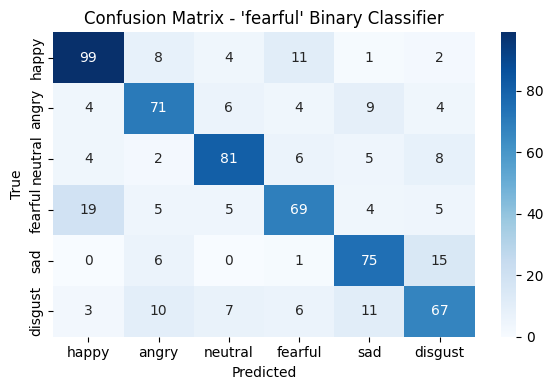

In [4]:
mlp = MLPClassifier(
    hidden_layer_sizes=(256, 128),
    activation="relu",
    solver="adam",
    alpha=1e-3,
    learning_rate_init=1e-3,
    max_iter=1000,
    random_state=42
)

mlp.fit(x_train, y_train)

y_pred = mlp.predict(x_test)
y_pred_proba = mlp.predict_proba(x_test)

print(classification_report(y_test, y_pred, target_names=classes))

cm = confusion_matrix(y_test, y_pred)

# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm, 
    annot=True, 
    fmt="d", 
    cmap="Blues",
    xticklabels=classes,
    yticklabels=classes
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix - 'fearful' Binary Classifier")
plt.tight_layout()
plt.show()


In [ ]:
#joblib.dump(mlp, 'general_mlp_model.pkl')

['general_mlp_model.pkl']

In [29]:
#predict_proba
probabilities = mlp.predict_proba(x_test).round(5)
scaler = joblib.load("mlp_prob_scaler.pkl")
probabilities = scaler.transform(probabilities)
probabilities_df = pd.DataFrame(probabilities, columns=mlp.classes_)
probabilities_df["predicted"] = mlp.predict(x_test)
first_best_indices = np.argsort(probabilities, axis=1)[:, -1]
second_best_indices = np.argsort(probabilities, axis=1)[:, -2]
probabilities_df["second_best"] = [mlp.classes_[i] for i in second_best_indices]
probabilities_df["emotion"] = y_test["emotion"]
probabilities_df["correct"] = probabilities_df["predicted"] == probabilities_df["emotion"]
probabilities_df["second_best_correct"] = probabilities_df["second_best"] == probabilities_df["emotion"]
probabilities_df["at_least_one_correct"] = probabilities_df["correct"] | probabilities_df["second_best_correct"]
probabilities_df["probability_difference"] = probabilities[np.arange(len(probabilities)), first_best_indices] - probabilities[np.arange(len(probabilities)), second_best_indices]

print(probabilities_df[:25])

probabilities_df.to_csv("mlp_grid_analysis_data.csv", index=False)

      angry   disgust  fearful    happy  neutral      sad predicted  \
0  -1.00000 -1.000000 -1.00000  1.00000 -1.00000 -1.00000     happy   
1   0.42980 -0.999660 -0.97710 -0.45306 -1.00000 -1.00000     angry   
2  -0.74966 -1.000000 -0.99392  0.74352 -0.99996 -0.99998     happy   
3  -0.99818 -0.998160 -0.99398 -0.99946  0.98978 -1.00000   neutral   
4  -0.02570 -0.998520  0.02404 -0.99986 -0.99996 -1.00000   fearful   
5  -0.95978 -1.000000 -0.99990  0.95930 -0.99964 -1.00000     happy   
6  -0.99736 -0.723517 -1.00000 -0.99950  0.68308 -0.96270   neutral   
7  -1.00000 -1.000000  0.99994 -1.00000 -1.00000 -0.99994   fearful   
8  -0.99980 -0.997680  0.09506 -0.99978 -0.36452 -0.73328   fearful   
9  -0.99786 -0.999120 -0.52712  0.52334 -0.99940 -0.99984     happy   
10  0.98326 -0.999700 -0.99908 -0.98450 -1.00000 -1.00000     angry   
11 -1.00000 -0.925219 -0.99772 -1.00000 -1.00000  0.92294       sad   
12 -0.99208 -0.631016 -0.99148 -0.99524  0.57038 -0.96056   neutral   
13 -0.

In [30]:
happy_model = joblib.load('happy_svc_model.pkl')
angry_model = joblib.load('angry_mlp_model.pkl')
disgust_model = joblib.load('disgust_svc_model.pkl')
fearful_model = joblib.load('fearful_mlp_model.pkl')
neutral_model = joblib.load('neutral_mlp_model.pkl')
sad_model = joblib.load('sad_mlp_model.pkl')

binary_models = {
    'happy': happy_model,
    'angry': angry_model,
    'disgust': disgust_model,
    'fearful': fearful_model,
    'neutral': neutral_model,
    'sad': sad_model
}

In [ ]:
def pipeline_predict_proba(pipeline, X):
    X_transformed = pipeline[:-1].transform(X)
    return pipeline.steps[-1][1].predict_proba(X_transformed)

probs_dict = {}
for emotion, model in binary_models.items():
    print(emotion)
    probs = pipeline_predict_proba(model, x_test)[:,1]
    probs_dict[f"{emotion}_prob"] = probs.round(5)

# Final ensemble DataFrame
df_ensemble = pd.DataFrame(probs_dict)
scaler = joblib.load('meta_scaler.pkl')
df_ensemble = pd.DataFrame(scaler.transform(df_ensemble), columns=df_ensemble.columns)
df_ensemble["emotion"] = y_test